In [1]:
from collections import Counter
from scipy.sparse import csr_matrix
from collections import defaultdict

def build_matrix_1(docs, labels):
    r""" Build sparse matrix from a list of documents, 
    each of which is a list of word/terms in the document.  
    """
        
    distinctWordsAndIndex = {}
    indexIter = 0
    nnz = 0
    
    for idx, doc in enumerate(docs):
        frequency = doc.split()
        while frequency:
            term, freq, *frequency = frequency
#             print(term)
            if term not in labels:
                continue
            
            nnz += 1
            if term not in distinctWordsAndIndex:
                distinctWordsAndIndex[term] = indexIter
                indexIter += 1    
    nrows = len(docs)
    ncols = len(distinctWordsAndIndex)
    
    # set up memory
    ind = np.zeros(nnz, dtype=int)
    val = np.zeros(nnz, dtype=int)
    ptr = np.zeros(nrows+1, dtype=int)

    i = 0
    j = 0
    for idx, doc in enumerate(docs):
        ptr[j] = i
        j += 1
        frequency = doc.split()
        while frequency:
            term, freq, *frequency = frequency
            if term not in labels:
                continue
            ind[i] = distinctWordsAndIndex[term]
            val[i] = int(freq)
            i += 1
    ptr[j] = i

    mat = csr_matrix((val, ind, ptr), shape=(nrows, ncols), dtype=np.double)
    mat.sort_indices()
    
    return mat


def csr_info(mat, name="", non_empy=False):
    r""" Print out info about this CSR matrix. If non_empy, 
    report number of non-empty rows and cols as well
    """
    if non_empy:
        print("%s [nrows %d (%d non-empty), ncols %d (%d non-empty), nnz %d]" % (
                name, mat.shape[0], 
                sum(1 if mat.indptr[i+1] > mat.indptr[i] else 0 
                for i in range(mat.shape[0])), 
                mat.shape[1], len(np.unique(mat.indices)), 
                len(mat.data)))
    else:
        print( "%s [nrows %d, ncols %d, nnz %d]" % (name, 
                mat.shape[0], mat.shape[1], len(mat.data)) )
        
# scale matrix and normalize its rows
def csr_idf(mat, copy=False, **kargs):
    r""" Scale a CSR matrix by idf. 
    Returns scaling factors as dict. If copy is True, 
    returns scaled matrix and scaling factors.
    """
    if copy is True:
        mat = mat.copy()
    nrows = mat.shape[0]
    nnz = mat.nnz
    ind, val, ptr = mat.indices, mat.data, mat.indptr
    # document frequency
    df = defaultdict(int)
    for i in ind:
        df[i] += 1
    # inverse document frequency
    for k,v in df.items():
        df[k] = np.log(nrows / float(v))  ## df turns to idf - reusing memory
    # scale by idf
    for i in range(0, nnz):
        val[i] *= df[ind[i]]
        
    return df if copy is False else mat

def csr_l2normalize(mat, copy=False, **kargs):
    r""" Normalize the rows of a CSR matrix by their L-2 norm. 
    If copy is True, returns a copy of the normalized matrix.
    """
    if copy is True:
        mat = mat.copy()
    nrows = mat.shape[0]
    nnz = mat.nnz
    ind, val, ptr = mat.indices, mat.data, mat.indptr
    # normalize
    for i in range(nrows):
        rsum = 0.0    
        for j in range(ptr[i], ptr[i+1]):
            rsum += val[j]**2
        if rsum == 0.0:
            continue  # do not normalize empty rows
        rsum = 1.0/np.sqrt(rsum)
        for j in range(ptr[i], ptr[i+1]):
            val[j] *= rsum
            
    if copy is True:
        return mat

In [2]:
#pre-processing

import nltk
from nltk.corpus import stopwords

#Filter labels with length <= 3 and is present in stop words
stop_words = stopwords.words('english')
with open("train.clabel", "r", encoding="utf8") as fh:
    labels = {}
    for idx, word in enumerate(fh.readlines()):
        if len(word.rstrip()) < 4 or word.rstrip() in stop_words:
            continue
        labels[str(idx+1)] = word.rstrip()
# print(labels)


In [3]:
import numpy as np
from sklearn.datasets import make_blobs

with open("train.dat", "r", encoding="utf8") as fh:
    rows = fh.readlines()

mat1 = build_matrix_1(rows, labels)
print(type(mat1))
mat2 = csr_idf(mat1, copy=True)
mat3 = csr_l2normalize(mat2, copy=True)

print(mat3.shape)
csr_info(mat3)

<class 'scipy.sparse.csr.csr_matrix'>
(8580, 26237)
 [nrows 8580, ncols 26237, nnz 962848]


In [4]:
from sklearn.cluster import KMeans
from numpy import *
%matplotlib inline
import matplotlib.pyplot as plt

num_clusters = 7
k_list = [] 
sse_list = [] 

for k in range(7, 8):
    total_SSE = 0

    X = mat3
    clusterMap = {}
    for idx,row in enumerate(X):
        clusterMap[idx] = idx
    finalClusterLabels = {}

    current_clusters = 1
    while current_clusters != num_clusters:
        print('============================================')
    #     print('final labels', finalClusterLabels)
    #     print('clusterMap',clusterMap)
        kmeans = KMeans(n_clusters=2).fit(X)
        print(kmeans.inertia_ )
        cluster_centers = kmeans.cluster_centers_
    #     print(X.shape)
        sse = [0]*2
        for point, label in zip(X, kmeans.labels_):
            sse[label] += np.square(point-cluster_centers[label]).sum()
        chosen_cluster = np.argmax(sse, axis=0)
        total_SSE += sse[np.argmin(sse, axis=0)]
        print('SSE', sse)
        print('Total SSE', total_SSE)
        print('chosen_cluster', chosen_cluster)
        print('kmeans labels', kmeans.labels_)
    #     print('cluster_centers', cluster_centers.shape)
        chosen_cluster_data = X[kmeans.labels_ == chosen_cluster]

        newClusterMap = {}
        clusterIter = 0
        for idx, x in enumerate(kmeans.labels_):
            if(x != chosen_cluster):
                finalClusterLabels[clusterMap[idx]] = current_clusters
            elif current_clusters + 1 == num_clusters:
                finalClusterLabels[clusterMap[idx]] = current_clusters + 1
            else:
                newClusterMap[clusterIter] = clusterMap[idx]
                clusterIter += 1 
        clusterMap = newClusterMap
        current_clusters += 1

        print('chosen_cluster_data', chosen_cluster_data.shape)
        assigned_cluster_data = X[kmeans.labels_ != chosen_cluster]
        print('assigned_cluster_data', assigned_cluster_data.shape)
        X = chosen_cluster_data
        print('finalClusterLabels - len ', len(finalClusterLabels))

    k_list.append(k)
    sse_list.append(kmeans.inertia_ )
        
print(k_list, sse_list)



# print(finalClusterLabels)
# print(mat3)
# km = KMeans(n_clusters=num_clusters)
# km.fit(mat3)

8300.524538657837
SSE [2728.4373945354196, 5572.087144122413]
Total SSE 2728.4373945354196
chosen_cluster 1
kmeans labels [0 1 1 ... 1 1 1]
chosen_cluster_data (5714, 26237)
assigned_cluster_data (2866, 26237)
finalClusterLabels - len  2866
5505.675363039572
SSE [579.5850036777313, 4926.0903593618505]
Total SSE 3308.022398213151
chosen_cluster 1
kmeans labels [1 1 1 ... 1 1 1]
chosen_cluster_data (5051, 26237)
assigned_cluster_data (663, 26237)
finalClusterLabels - len  3529
4866.3769424282145
SSE [538.7708626944333, 4327.606079733769]
Total SSE 3846.793260907584
chosen_cluster 1
kmeans labels [1 1 1 ... 1 1 1]
chosen_cluster_data (4433, 26237)
assigned_cluster_data (618, 26237)
finalClusterLabels - len  4147
4273.614466372381
SSE [632.5829664132198, 3641.0314999591683]
Total SSE 4479.376227320804
chosen_cluster 1
kmeans labels [1 1 1 ... 1 1 1]
chosen_cluster_data (3716, 26237)
assigned_cluster_data (717, 26237)
finalClusterLabels - len  4864
3614.8284068775974
SSE [890.129602299173, 

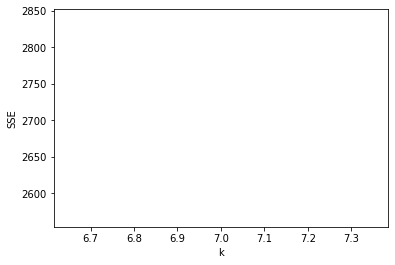

In [5]:
plt.plot(k_list, sse_list)
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()

In [6]:
#Compare with last output

from sklearn import metrics
from sklearn.metrics.cluster import normalized_mutual_info_score

with open("output.dat", "r", encoding="utf8") as fh:
    labels_true = fh.readlines()

# Number of clusters in labels, ignoring noise if present.
labels = [finalClusterLabels[key] for key in sorted(finalClusterLabels.keys())]
# labels = km.labels_
# labels_true =  km.labels_.tolist()

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
print('NMI: %s' % normalized_mutual_info_score(labels, labels_true))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
 % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
 % metrics.adjusted_mutual_info_score(labels_true, labels))

Estimated number of clusters: 7
NMI: 0.816866022665614
Homogeneity: 0.814
Completeness: 0.819
V-measure: 0.817
Adjusted Rand Index: 0.814
Adjusted Mutual Information: 0.817


In [7]:
with open("output.dat", "w", encoding="utf8") as file:
     for item in labels:
        file.write("%s\n" % str(item))
len(rows)

8580

In [8]:
res = {}
with open('output.dat', 'r') as resultFile:
    labels_true = resultFile.readlines()
    for (row, label) in enumerate(labels_true):  

        if not label in res:
            res[label] = 1
        else:
            res[label] = res[label] + 1
            
#         resultFile.write(str(label + 1) + '\n');
res

{'1\n': 2866,
 '7\n': 1912,
 '6\n': 865,
 '5\n': 939,
 '3\n': 618,
 '2\n': 663,
 '4\n': 717}